# Detecting planes using transfer learning
From: https://keras.io/guides/transfer_learning/

In [7]:
# Setup
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [8]:

data_dir = "/tf/export"
batch_size = 32
img_height = 180
img_width = 180
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


print("Number of training samples: %d" % tf.data.experimental.cardinality(train_ds))
print(
    "Number of validation samples: %d" % tf.data.experimental.cardinality(validation_ds)
)


Found 3798 files belonging to 2 classes.
Using 3039 files for training.
Found 3798 files belonging to 2 classes.
Using 759 files for validation.
Number of training samples: 95
Number of validation samples: 24


### Using random data augmentation

When you don't have a large image dataset, it's a good practice to artificially
 introduce sample diversity by applying random yet realistic transformations to
the training images, such as random horizontal flipping or small random rotations. This
helps expose the model to different aspects of the training data while slowing down
 overfitting.

In [11]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

Let's visualize what the first image of the first batch looks like after various random transformations:

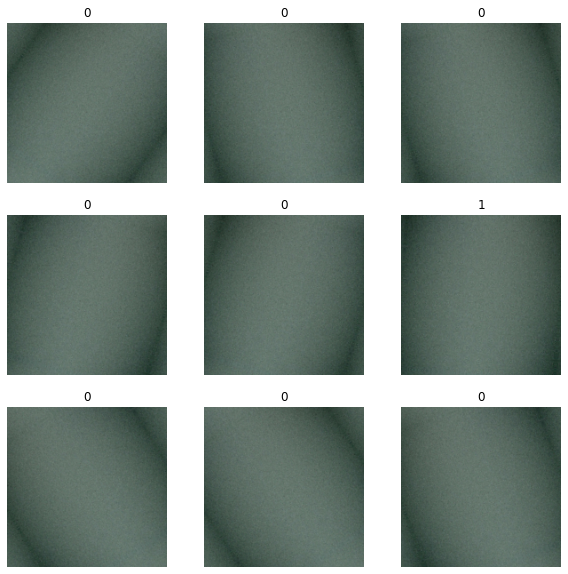

In [12]:
import numpy as np

for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[i]))
        plt.axis("off")

## Build a model

Now let's built a model that follows the blueprint we've explained earlier.

Note that:

- We add a `Normalization` layer to scale input values (initially in the `[0, 255]`
 range) to the `[-1, 1]` range.
- We add a `Dropout` layer before the classification layer, for regularization.
- We make sure to pass `training=False` when calling the base model, so that
it runs in inference mode, so that batchnorm statistics don't get updated
even after we unfreeze the base model for fine-tuning.

In [15]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(img_width, img_height, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(img_width, img_height, 3))
x = data_augmentation(inputs)  # Apply random data augmentation

# Pre-trained Xception weights requires that input be normalized
# from (0, 255) to a range (-1., +1.), the normalization layer
# does the following, outputs = (inputs - mean) / sqrt(var)
norm_layer = keras.layers.experimental.preprocessing.Normalization()
mean = np.array([127.5] * 3)
var = mean ** 2
# Scale inputs to [-1, +1]
x = norm_layer(x)
norm_layer.set_weights([mean, var])

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, None, None, 3)     0         
_________________________________________________________________
normalization_1 (Normalizati (None, 180, 180, 3)       7         
_________________________________________________________________
xception (Functional)        (None, 6, 6, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2049

## Train the top layer

In [16]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 20
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/20
95/95 [==============================] - 69s 634ms/step - loss: 0.4407 - binary_accuracy: 0.8225 - val_loss: 0.2749 - val_binary_accuracy: 0.9249
Epoch 2/20
95/95 [==============================] - 57s 567ms/step - loss: 0.2814 - binary_accuracy: 0.9188 - val_loss: 0.2351 - val_binary_accuracy: 0.9328
Epoch 3/20
95/95 [==============================] - 57s 565ms/step - loss: 0.2416 - binary_accuracy: 0.9265 - val_loss: 0.2083 - val_binary_accuracy: 0.9460
Epoch 4/20
95/95 [==============================] - 57s 563ms/step - loss: 0.2216 - binary_accuracy: 0.9338 - val_loss: 0.1877 - val_binary_accuracy: 0.9499
Epoch 5/20
95/95 [==============================] - 59s 589ms/step - loss: 0.2069 - binary_accuracy: 0.9388 - val_loss: 0.1741 - val_binary_accuracy: 0.9513
Epoch 6/20
95/95 [==============================] - 56s 555ms/step - loss: 0.1861 - binary_accuracy: 0.9480 - val_loss: 0.1636 - val_binary_accuracy: 0.9499
Epoch 7/20
95/95 [==============================] - 56s 56

## Do a round of fine-tuning of the entire model

Finally, let's unfreeze the base model and train the entire model end-to-end with a low
 learning rate.

Importantly, although the base model becomes trainable, it is still running in
inference mode since we passed `training=False` when calling it when we built the
model. This means that the batch normalization layers inside won't update their batch
statistics. If they did, they would wreck havoc on the representations learned by the
 model so far.

In [18]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 10
history = model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, None, None, 3)     0         
_________________________________________________________________
normalization_1 (Normalizati (None, 180, 180, 3)       7         
_________________________________________________________________
xception (Functional)        (None, 6, 6, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2049

## Visualize training results

Create plots of loss and accuracy on the training and validation sets.
From: https://www.tensorflow.org/tutorials/images/classification#visualize_training_results

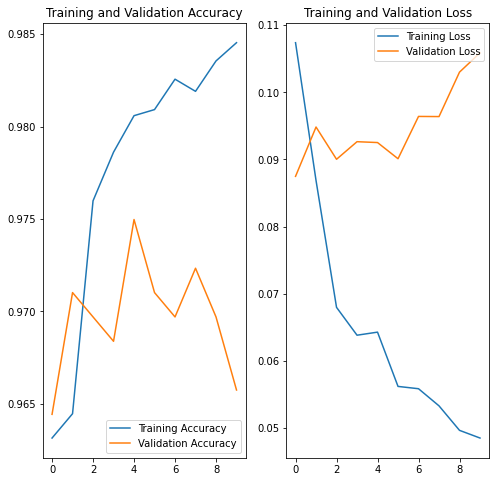

In [20]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Try it out

In [24]:
image_size = (img_width, img_height)
img = keras.preprocessing.image.load_img(
    "/tf/export/plane/ck80sulie7xig0874x0d7e4u6%2F7a7f7a31-a8a5-0e1a-0414-b88a6869b333-A451CF_2021-01-13-12-57-57.jpg", target_size=image_size
)
img = keras.preprocessing.image.load_img(
    "/tf/export/noplane/ck80sulie7xig0874x0d7e4u6%2F7cd1f1a2-bfe7-29d4-d762-a60693d54de3-0D08B3_2021-01-09-20-42-22.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent No Plane and %.2f percent Plane."
    % (100 * (1 - score), 100 * score)
)

This image is 857.24 percent No Plane and -757.24 percent Plane.


# Save Model

In [25]:
model.save("/tf/dataset/plane-detector")

INFO:tensorflow:Assets written to: /tf/dataset/plane-detector/assets
